In [1]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML models and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For saving model
import joblib
import os


In [9]:
# Load feature-engineered data (from Phase 4)
df = pd.read_csv('C:/Users/Saisa/Downloads/Walmart_Sales/data/processed/feature_engineered_sales.csv', parse_dates=['date'])

# Sort by date to ensure time-based splitting
df = df.sort_values('date')

# Check structure
df.head()


,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,year,month,...,sales_roll_13,sales_roll_26,sales_roll_52,cumulative_sales,sales_diff_1,sales_diff_4,avg_sales_per_store,promo_last_week,promo_next_week,store_encoded
71,2,2010-01-10,1827440.43,0,69.24,2.603,211.329874,8.163,2010,1,...,1.994718e+06,0.0,0.0,29895763.79,-11688.40,-53462.19,1.951955e+06,0.0,0.0,1
470,9,2010-01-10,495692.19,0,69.08,2.603,215.214134,6.560,2010,1,...,5.228107e+05,0.0,0.0,7841736.68,10856.99,10303.04,5.524182e+05,0.0,0.0,8
1211,22,2010-01-10,905987.17,0,69.31,2.717,136.629757,8.572,2010,1,...,1.049318e+06,0.0,0.0,15580135.73,-18187.23,-186667.09,1.036432e+06,0.0,0.0,21
755,14,2010-01-10,1855703.66,0,70.58,2.707,182.716838,8.724,2010,1,...,2.230819e+06,0.0,0.0,33479814.55,-336064.10,-380505.47,2.075189e+06,0.0,0.0,13
1667,30,2010-01-10,445475.30,0,70.28,2.603,211.329874,8.163,2010,1,...,4.582576e+05,0.0,0.0,6867932.04,-9687.62,9181.90,4.412639e+05,0.0,0.0,29


In [4]:
# Your prediction target
target = 'weekly_sales'

# Remove columns not suitable for modeling
drop_cols = ['date', 'weekly_sales', 'store', 'dept']

# Choose all other numeric columns as input features
features = [col for col in df.columns if col not in drop_cols and df[col].dtype != 'object']

# Define X (features) and y (target)
X = df[features]
y = df[target]


In [5]:
# Use 80% of earliest dates for training, 20% of latest for testing
split_date = df['date'].quantile(0.8)

X_train = X[df['date'] < split_date]
X_test = X[df['date'] >= split_date]
y_train = y[df['date'] < split_date]
y_test = y[df['date'] >= split_date]


In [6]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
}


In [11]:
# Store results
results = []

# Train and test each model
for name, model in models.items():
    print(f"Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2 Score': round(r2, 4)
    })

    # Save the best model (optional: only XGBoost)
    if name == 'XGBoost':
        joblib.dump(model, 'C:/Users/Saisa/Downloads/Walmart_Sales/models/xgboost_sales_model.pkl')

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('C:/Users/Saisa/Downloads/Walmart_Sales/outputs/model_metrics.csv', index=False)
results_df


Training: Linear Regression
Training: Random Forest
Training: XGBoost


,Model,MAE,RMSE,R2 Score
0,Linear Regression,39256.85,57395.46,0.9895
1,Random Forest,24005.59,38692.81,0.9952
2,XGBoost,26394.50,39882.65,0.9949


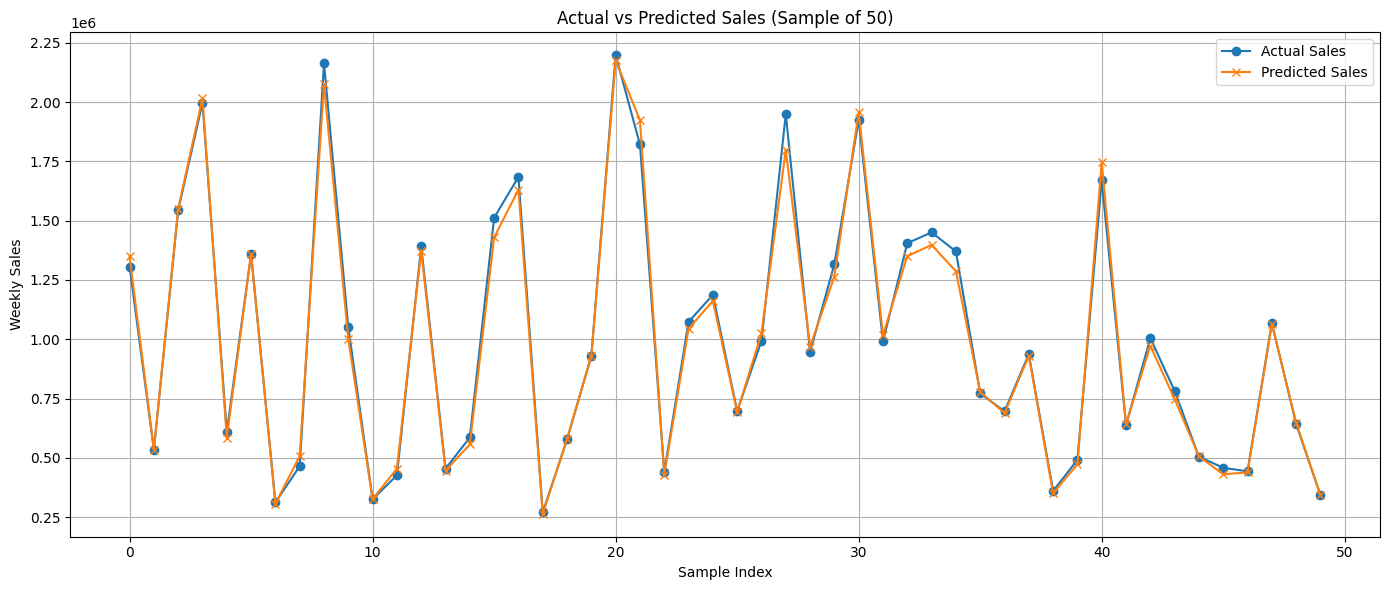

In [13]:
import os
import matplotlib.pyplot as plt

# Predict
best_model = joblib.load('C:/Users/Saisa/Downloads/Walmart_Sales/models/xgboost_sales_model.pkl')
y_pred = best_model.predict(X_test)

# Ensure save directory exists
os.makedirs("C:/Users/Saisa/Downloads/Walmart_Sales/outputs/plots", exist_ok=True)

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:50], label='Actual Sales', marker='o')
plt.plot(y_pred[:50], label='Predicted Sales', marker='x')
plt.title('Actual vs Predicted Sales (Sample of 50)')
plt.xlabel('Sample Index')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid()
plt.tight_layout()

# Save plot
plt.savefig("C:/Users/Saisa/Downloads/Walmart_Sales/outputs/plots/predicted_vs_actual.png")
plt.show()
